# Comparison of the radial matrix elements to pairinteraction and ARC

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

from ryd_numerov.rydberg import RydbergState
from ryd_numerov.units import ureg

In [ ]:
# A few exemplary test cases, where pairinteraction and ARC do fail in various ways
dn, dl, dj, dm = [
    (3, 1, 0, 0),
    (1, 0, 0, 0),
    (2, 0, 0, 0),
    (2, 2, 2, 0),
    (5, 1, 0, 0),
    (5, 2, 1, 0),
][0]

n_list = np.arange(20, 150)
qn1_list = [(n1, n1 - 1, n1 - 0.5, n1 - 0.5) for n1 in n_list]
qn2_list = [(n + dn, l + dl, j + dj, m + dm) for n, l, j, m in qn1_list]

In [3]:
results = {}

In [4]:
for species in ["Rb", "H"]:
    key = "Numerov " + species
    results[key] = []
    for qn1, qn2 in zip(qn1_list, qn2_list):
        print(f"n={qn1[0]}", end="\r")
        state_i = RydbergState("Rb", qn1[0], qn1[1], qn1[2])
        state_i.create_model(add_spin_orbit=species != "H")
        state_f = RydbergState("Rb", qn2[0], qn2[1], qn2[2])
        state_f.create_model(add_spin_orbit=species != "H")
        radial_me = state_i.calc_radial_matrix_element(state_f, 1, unit="a.u.")
        results[key].append(radial_me)

    results[key] = np.array(results[key]) * ureg.Quantity(1, "bohr_radius").to("micrometer").magnitude

In [5]:
from pairinteraction import pireal as pi

Path(".pairinteraction_cache").mkdir(exist_ok=True)
cache = pi.MatrixElementCache("./.pairinteraction_cache/")

for method in ["Numerov", "Whittaker"]:
    key = f"Pairinteraction {method}"
    cache.setMethod(pi.NUMEROV if method == "Numerov" else pi.WHITTAKER)
    results[key] = []
    for qn1, qn2 in zip(qn1_list, qn2_list):
        print(f"n={qn1[0]}", end="\r")
        state_i = pi.StateOne("Rb", int(qn1[0]), int(qn1[1]), qn1[2], qn1[3])
        state_f = pi.StateOne("Rb", int(qn2[0]), int(qn2[1]), qn2[2], qn2[3])
        results[key].append(cache.getRadial(state_f, state_i, 1))

    results[key] = np.array(results[key])

In [6]:
import arc
import arc_fixed

atom = arc.Rubidium87()

for use_fixed_arc in [False, True]:
    key = "ARC fixed" if use_fixed_arc else "ARC default"
    results[key] = []
    for qn1, qn2 in zip(qn1_list, qn2_list):
        print(f"n={qn1[0]}", end="\r")
        v = arc_fixed.getRadialMatrixElement(
            atom, int(qn1[0]), int(qn1[1]), qn1[2], int(qn2[0]), int(qn2[1]), qn2[2], use_fixed_arc=use_fixed_arc
        )
        results[key].append(v)

    results[key] = np.array(results[key]) * ureg.Quantity(1, "bohr_radius").to("micrometer").magnitude

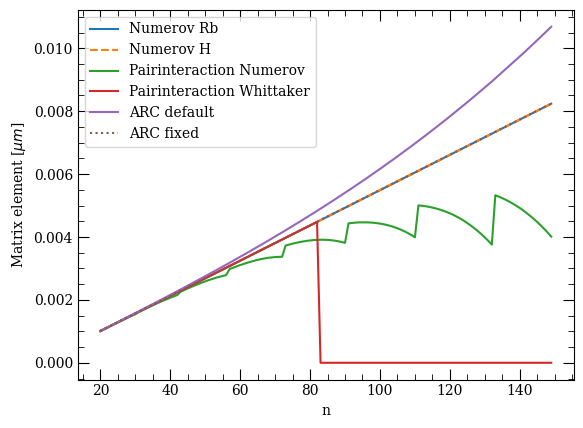

In [7]:
ls_dict = {"Numerov H": "--", "ARC fixed": ":"}

fig, ax = plt.subplots()

for key, values in results.items():
    ls = ls_dict.get(key, "-")
    ax.plot(n_list, values, ls=ls, label=key)

ax.set_xlabel("n")
ax.set_ylabel(r"Matrix element [$\mu m$]")

ax.legend()
plt.show()